# Performing Spatial Queries

## Introduction

Spatial queries allows you to select features in a layer by their spatial relationships with features from another layer. GeoPandas provides `sjoin()` and `sjoin_nearest()` functions that can be used to perform a spatial query.

## Overview of the Task

We will be working with 2 data layers for the city of Melbourne, Australia. Given the data layers for the pubs and bars in the city and the locations of all metro stations, we want to find out which bars and pubs are within 500 meters of a metro station.

**Input Layers**:
* `metro_stations_accessbility.zip`: A shapefile of metro stations in Melbourne
* `Bars_and_pubs__with_patron_capacity.csv`: CSV file with location of bars and pubs in Melbournse

**Output**:
* `spatial_query.gpkg`: A GeoPackage containing all bars and pubs within 500 meters of a metro station

**Data Credit**

* 2019 The City of Melbourne Open Data Portal. Data provided by Metro Trains Melbourne and Census of Land Use and Employment (CLUE)


**Watch Video Walkthrough** <a href='https://www.youtube.com/watch?v=V-gyuP7vMSg' target='_blank'><img src='https://github.com/spatialthoughts/geopython-tutorials/blob/main/images/yt_logo.png?raw=1'></a>


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [4]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [5]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [9]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

download(data_url + 'Bars_and_pubs__with_patron_capacity.csv')
download(data_url + 'metro_stations_accessbility.zip')

Downloaded data/Bars_and_pubs__with_patron_capacity.csv
Downloaded data/metro_stations_accessbility.zip


## Procedure

Read the `Bars_and_pubs__with_patron_capacity.csv` file and convert it to a GeoDataFrame.

In [43]:
csv_file = 'Bars_and_pubs__with_patron_capacity.csv'
csv_path = os.path.join(data_folder, csv_file)
barspubs_df = pd.read_csv(csv_path) 
barspubs_df.iloc[:, :5]

,Census year,Block ID,Property ID,Base property ID,Street address
0,2002,247,106238,106238,192-202 Lygon Street
1,2002,252,106244,106244,160-162 Lygon Street
2,2006,16,104018,104018,172-192 Flinders Street
3,2002,214,106186,106186,414-422 Lygon Street
4,2008,76,589841,105749,221 Little Lonsdale Street
...,...,...,...,...,...
3333,2017,85,105746,105746,183-265 La Trobe Street
3334,2017,74,104662,104662,106-112 Hardware Street
3335,2017,268,108154,108153,49 Rathdowne Street
3336,2017,104,104085,104085,167-175 Franklin Street


You will note that the data contains multiple features for each establishment from different years. Let's sort by *Property ID* and check.

In [44]:
barspubs_df = barspubs_df.sort_values('Property ID')
barspubs_df.iloc[:, :5]

,Census year,Block ID,Property ID,Base property ID,Street address
3129,2017,103,100160,100160,196-200 A'Beckett Street
709,2011,103,100160,100160,196-200 A'Beckett Street
2553,2015,103,100160,100160,196-200 A'Beckett Street
247,2008,103,100160,100160,196-200 A'Beckett Street
2201,2010,103,100160,100160,196-200 A'Beckett Street
...,...,...,...,...,...
2579,2015,1105,628712,628712,717-731 Collins Street
2832,2016,66,635138,635138,13 Heffernan Lane
3069,2017,66,635138,635138,13 Heffernan Lane
3058,2016,270,664626,104468,230 Grattan Street


We are interested only in the location of the establishment. So we can de-duplicate the dataframe and keep only 1 record per unique *Property ID*.

In [45]:
barspubs_df = barspubs_df.drop_duplicates(subset=['Property ID'], keep='first')
barspubs_df.iloc[:, :5]

,Census year,Block ID,Property ID,Base property ID,Street address
3129,2017,103,100160,100160,196-200 A'Beckett Street
1087,2011,409,100441,100441,118-126 Ireland Street
410,2004,315,100514,100514,204-206 Arden Street
1501,2009,33,100727,100727,5-9 Bank Place
1159,2013,33,100730,100730,12-16 Bank Place
...,...,...,...,...,...
1601,2009,2391,616966,616966,2 Boundary Road
1182,2013,1110,620312,593737,23-37 Star Crescent
3028,2016,1105,628712,628712,717-731 Collins Street
2832,2016,66,635138,635138,13 Heffernan Lane


Now that we are done with data cleaning, let's turn this dataframe in to a spatial layer. The location of the establishment is defined using the *x coordinate* and *y coordinate* columns.

In [46]:
barspubs_df.iloc[:, -5:]

,Trading name,Number of patrons,x coordinate,y coordinate,Location
3129,Nomads Industry Backpackers,200,144.957445,-37.809985,"(-37.80998494, 144.9574447)"
1087,Railway Hotel,241,144.942118,-37.806054,"(-37.80605366, 144.9421177)"
410,North Melbourne Football Club Social Club,210,144.941312,-37.799055,"(-37.79905531, 144.9413118)"
1501,Mitre Tavern,300,144.960311,-37.816805,"(-37.81680457, 144.9603112)"
1159,Melbourne Savage Club,90,144.960577,-37.816545,"(-37.81654467, 144.9605765)"
...,...,...,...,...,...
1601,Vodka Locka & Red Leaf Restaurant,40,144.939233,-37.795318,"(-37.79531826, 144.9392333)"
1182,Harbour Town Hotel,498,144.937830,-37.813150,"(-37.81315031, 144.9378299)"
3028,Bar Nicional,75,144.950093,-37.820687,"(-37.82068699, 144.9500934)"
2832,Union Electric,72,144.966591,-37.811802,"(-37.81180178, 144.9665913)"


Create a geometry column and use it to define a new GeoDataFrame.

In [27]:
geometry = gpd.points_from_xy(barspubs_df['x coordinate'],barspubs_df['y coordinate'])
barspubs_gdf = gpd.GeoDataFrame(barspubs_df, crs='EPSG:4326', geometry=geometry)

Next, we will read the zipped shapefile of metro stations as a GeoDataFrame.

In [22]:
zip_file = 'metro_stations_accessbility.zip'
zip_path = os.path.join('zip://', data_folder, zip_file)
metrostations_gdf = gpd.read_file(zip_path)
metrostations_gdf

,station,pids,he_loop,lift,geometry
0,Alamein,No,No,No,POINT (145.07956 -37.86884)
1,Albion,Dot Matrix,No,No,POINT (144.82471 -37.77766)
2,Alphington,Dot Matrix,No,No,POINT (145.03125 -37.7784)
3,Altona,LCD,No,No,POINT (144.8306 -37.86725)
4,Anstey,No,No,No,POINT (144.96056 -37.7619)
...,...,...,...,...,...
214,Williams Landing,Dot Matrix,Yes,Yes,POINT (144.74719 -37.8701)
215,Aircraft,No,No,No,POINT (144.76081 -37.8666)
216,Flemington Racecourse,No,No,No,POINT (144.9072 -37.78759)
217,Showgrounds,No,No,No,POINT (144.91498 -37.78355)


Visualize the layers.

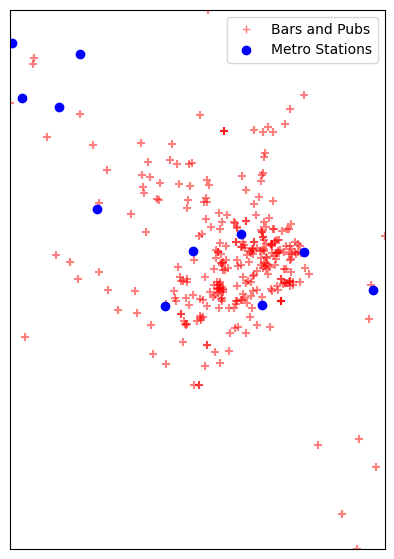

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf.plot(ax=ax, color='red', alpha=0.5, marker='+')
metrostations_gdf.plot(ax=ax, color='blue', alpha=1, marker='o')

minx, miny, maxx, maxy = barspubs_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Stations', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

For performing any analysis, we must use a Projected CRS. Let's reproject to a local CRS for Melbourne. *GDA 2020 / MGA zone 55 EPSG:7855*.

In [28]:
metrostations_gdf_reprojected = metrostations_gdf.to_crs('EPSG:7855')
barspubs_gdf_reprojected = barspubs_gdf.to_crs('EPSG:7855')

We now buffer the metro stations to 500 meters. GeoPandas uses shapely for buffer operation. We specify [buffer parameters](https://shapely.readthedocs.io/en/latest/manual.html#constructive-methods) to match QGIS's default style.

In [29]:
radius = 500

buffer_geometry = metrostations_gdf_reprojected.buffer(
    radius, resolution=5, cap_style=1, join_style=1, mitre_limit=2)
metrostations_gdf_reprojected['geometry'] = buffer_geometry

Visualize the buffers.

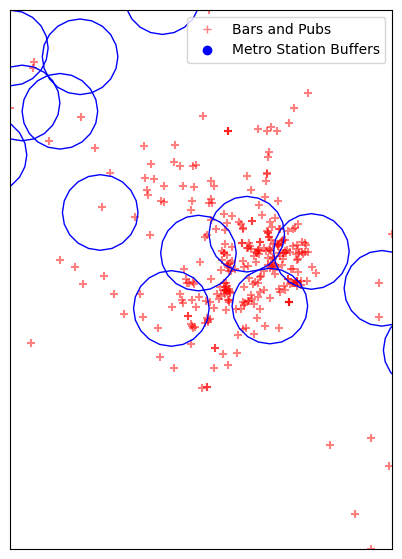

In [30]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf_reprojected.plot(ax=ax, color='red', alpha=0.5, marker='+')
metrostations_gdf_reprojected.plot(ax=ax, facecolor='none', edgecolor='blue',  alpha=1, marker='o')

minx, miny, maxx, maxy = barspubs_gdf_reprojected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Station Buffers', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

As we want to do a spatial join, we need to dissolve the resulting buffers. Otherwise we will get 1 feature for every intersecting buffer

In [31]:
metrostations_gdf_reprojected['dissolvefield'] = 1
dissolved_buffers = metrostations_gdf_reprojected.dissolve(by='dissolvefield')

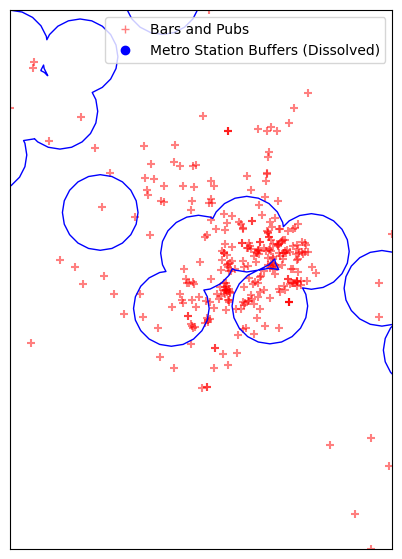

In [32]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf_reprojected.plot(ax=ax, color='red', alpha=0.5, marker='+')
dissolved_buffers.plot(ax=ax, facecolor='none', edgecolor='blue',  alpha=1)

minx, miny, maxx, maxy = barspubs_gdf_reprojected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Station Buffers (Dissolved)', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

Now do a spatial join to select all bars and pubs within the dissolved buffer region.

In [37]:
selected = barspubs_gdf_reprojected.sjoin(
    dissolved_buffers, how='inner', predicate='within')

For our final visualization, we show the selected establishments within the buffer zone.

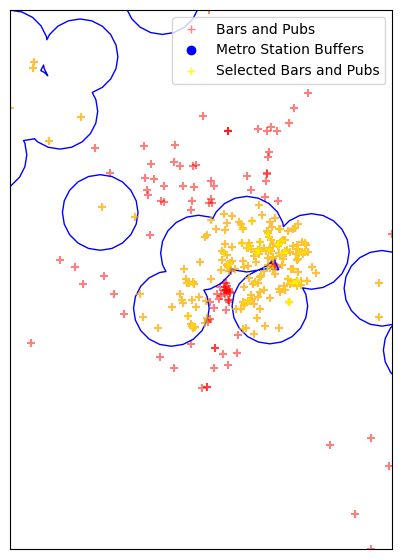

In [35]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf_reprojected.plot(ax=ax, color='red', alpha=0.5, marker='+')
dissolved_buffers.plot(ax=ax, facecolor='none', edgecolor='blue',  alpha=1)
selected.plot(ax=ax, color='yellow', alpha=0.5, marker='+')

minx, miny, maxx, maxy = barspubs_gdf_reprojected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Station Buffers', ls='')[0],
    plt.plot([],[], color='yellow', alpha=1, marker='+', label='Selected Bars and Pubs', ls='')[0]
]

ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Finally, we save all our layers into a output geopackage.

In [38]:
output_file = 'spatial_query.gpkg'
output_path = os.path.join(output_folder, output_file)

barspubs_gdf_reprojected.to_file(filename=output_path, layer='bars_and_pubs')
metrostations_gdf_reprojected.to_file(filename=output_path, layer='metro_stations')
selected.to_file(filename=output_path, layer='selected_locations')

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>